## **라이브러리 다운로드 및 불러오기**

In [ ]:
## 라이브러리 다운로드

# 통계
!pip3 install numpy scipy patsy pandas

# 한글깨짐 해결('코드 실행' → '런타임' → '세션 다시시작' 실행)
!pip install matplotlib -U
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 워드클라우드
!pip install nltk
!pip install wordcloud
!pip install konlpy

# 연관성분석
!pip install apyori

In [ ]:
## 라이브러리 불러오기

# 데이터 핸들링
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import re

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # plot "-" 부호 표기 설정

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# 통계
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from apyori import apriori
import networkx as nx

# NLP
import nltk
from wordcloud import WordCloud
from nltk import Text
import nltk
from nltk import FreqDist
import gensim
from gensim import *
from gensim import corpora, models
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim import utils
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# 경고 안내 무시
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 200)       # row 출력제한 해제
pd.set_option('display.max_columns', 100)   # column 출력제한 해제

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


___

### **함수 생성**


In [ ]:
## 함수 정의

# 시각화 옵션 정의(1)
def plot_option01():
    plt.rc('font', family='NanumBarunGothic')                      # 폰트
    plt.xticks(rotation=0, size = 9, fontweight ="bold")           # X축 크기 및 굵기
    plt.yticks(size = 9, fontweight ="bold")                       # y축 크기 및 굵기
    plt.grid(False)                                                # 차트 선 제거

# 시각화 옵션 정의(2)
def plot_option02(input_xlabel, input_ylabel, plot_name):
    plot_option01()                                                # 시각화 옵션 정의(1) 불러오기
    plt.xlabel(input_xlabel, fontweight='bold')                    # x축 이름
    plt.ylabel(input_ylabel, fontweight='bold')                    # y축 이름
    plt.title(plot_name, fontsize=11, fontweight ="bold")          # 차트 이름

# 일반 시각화 그래프 정의
def make_plot01(input_xlabel, input_ylabel, plot_name, data01):
    get_data = data01.value_counts().sort_index(ascending=False)   # 시각화 옵션 정의(2) 불러오기
    get_data.plot(kind='bar', color='k', alpha = 0.8)              # 차트 출력
    plot_option02(input_xlabel, input_ylabel, plot_name)

# 그룹바이 시각화 그래프 정의
def groupby_make_plot02(input_xlabel, input_ylabel, plot_name, imput_plot01, input_plot02, data, number_select):
  # 기호에 따라 카운트 혹은 평점 방법으로 측정
  if number_select =="count":
    data.groupby(imput_plot01)[input_plot02].count().sort_index(ascending=True).plot(kind='bar', color='k')
  elif number_select =="mean":
    data.groupby(imput_plot01)[input_plot02].mean().sort_index(ascending=True).plot(kind='bar', color='k')

  plot_option02(input_xlabel, input_ylabel, plot_name)            # 시각화 옵션 정의(2) 불러오기

---

## **데이터: KGA대상 이전(22.11.16 이전)**

In [ ]:
# 데이터 불러오기
MDunpa_df06 = pd.read_csv('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_06.csv')

## 데이터 전처리
del MDunpa_df06["Unnamed: 0"]                                                          # 불필요 변수 제거
MDunpa_df06 = MDunpa_df06[MDunpa_df06["filtering"]!="불일치"]                          # 필터링(평점 및 감성극성이 불일치하는 데이터 제거)

In [ ]:
# KGA대상 전/후, 유저들의 감정 상태 확인
MDunpa_df06[["리뷰_ID", "Binary", "감정"]]. groupby(['Binary', '감정']).count()

리뷰_ID
Binary 감정       
After  공포     58
       놀람     26
       분노     39
       슬픔    110
       중립    144
       행복    219
       혐오    174
Befor  공포    965
       놀람    389
       분노    221
       슬픔   1444
       중립   1452
       행복   4278
       혐오   1134

In [ ]:
### 데이터 재정의: KGA대상 이전(22.11.16 이전)

## 데이터 전처리
Before_MDunpa_df06 = MDunpa_df06[MDunpa_df06["Binary"]=="Befor"]                       # 필터링(22.11.16 이전 고객 리뷰 데이터)
Before_MDunpa_df06 = Before_MDunpa_df06.reset_index()                                  # 인덱스 초기화
Before_MDunpa_df06["작성일자"] = pd.to_datetime(Before_MDunpa_df06["작성일자"])        # 데이터 형태 변환
del Before_MDunpa_df06["index"]                                                        # 불필요 데이터 제거

# 데이터 타입 변환
Before_MDunpa_df06 = Before_MDunpa_df06.astype("str")
Before_MDunpa_df06 = Before_MDunpa_df06.astype({'평점': 'int', '감성점수': 'int', '유용성': 'int', '핵심평점(속01)': 'float','주변평점(속02)': 'float','감성평점(속03)': 'float'})
Before_MDunpa_df06["작성일자"] = pd.to_datetime(Before_MDunpa_df06["작성일자"])

# 데이터 순서 변경
Before_MDunpa_df06 = Before_MDunpa_df06[['리뷰_ID', '고객_ID', '평점', '평점극성', '핵심평점(속01)', '주변평점(속02)', '감성평점(속03)', '감성점수', '감성극성', '유용성', '(원본)리뷰어',
                                         '(정제)리뷰어', '품사(빈도)', '품사(감성)', '작성일자', '년', '월', '일', 'Binary', 'filtering', '감정', 'cluster_03', 'cluster_04', 'cluster_05']]

# 데이터 변수명 변경
Before_MDunpa_df06.columns = ['리뷰_ID', '고객_ID', '평점', '평점극성', '핵심평점(속성01)', '주변평점(속성02)', '감성평점(속성03)','감성점수', '감성극성', '유용성', '(원본)리뷰어',
                              '(정제)리뷰어', '품사(빈도)', '품사(감성)', '작성일자','년', '월', '일', '게임대상(전/후)', '불일치', '감정', '군집_03', '군집_04','군집_05']

# 데이터 확인
print(Before_MDunpa_df06.shape)
Before_MDunpa_df06.tail()

(9883, 24)


,리뷰_ID,고객_ID,평점,평점극성,핵심평점(속성01),주변평점(속성02),감성평점(속성03),감성점수,감성극성,유용성,(원본)리뷰어,(정제)리뷰어,품사(빈도),품사(감성),작성일자,년,월,일,게임대상(전/후),불일치,감정,군집_03,군집_04,군집_05
9878,10783,iIiIiIiIiIi l,1,부정,0.5000,0.5000,0.0000,0,중립,0,유저 적대운영이 에픽세븐급,유저적대 운영이 에픽세븐급,"['유저', '적대', '운영', '에픽', '세븐']","['유저', '적대', '운영', '에픽', '세븐']",2022-10-14,2022,10,14,Befor,일치,놀람,0,0,0
9879,10785,서서,1,부정,0.3333,0.6667,0.0000,-4,부정,0,"로드맵도 못 지키는 무능한 개발진과, 그걸 제대로 커버도 못 치면서 유저 불편은 계...",로드맵도 못 지키는 무능한 개발진과 그걸 제대로 커버도 못 치면서 유저 불편은 계속...,"['로드맵', '못', '개발', '진과', '제대로', '커버', '못', '치면...","['로드맵', '지키는', '무능한', '개발', '진과', '그걸', '제대로',...",2022-10-14,2022,10,14,Befor,일치,혐오,0,0,0
9880,10786,초콜릿우유,1,부정,0.0000,1.0000,0.0000,0,중립,0,꿀통 파괴를 누구보다 빠르게 업뎃과 개선을 무조건 느릿느릿하게 그러니 평점 1점 넉...,꿀통 파괴를 누구보다 빠르게 업뎃과 개선을 무조건 느릿느릿하게 그러니 평점 점 넉넉...,"['꿀통', '파괴', '누구', '업뎃', '개선', '무조건', '느릿느릿', ...","['꿀통', '파괴', '빠르게', '업뎃', '개선', '무조건', '느릿느릿',...",2022-10-14,2022,10,14,Befor,일치,행복,0,0,0
9881,10788,갈갈,5,긍정,0.0000,0.0000,0.0000,2,긍정,0,왜 이제 시작했지 .. 너무 재밌는데,왜 이제 시작했지 너무 재밌는 데,"['왜', '이제', '시작', '데']","['이제', '시작', '했지', '너무', '재밌는']",2022-10-14,2022,10,14,Befor,일치,중립,0,0,0
9882,10789,박은찬,1,부정,0.5000,0.5000,0.0000,0,중립,0,업데이트 한달에 한번하면서 그것도 못지켜서 오즈마연기하는 레전드게임 과금한거랑 시간...,업데이트 한 달에 한 번 하면서 그것도 못 지켜서 오즈마 연기하는 레전드 게임과 금...,"['업데이트', '달', '번', '그것', '못', '오즈', '마', '연기',...","['업데이트', '그것', '지켜서', '오즈', '연기', '하는', '레전드',...",2022-10-14,2022,10,14,Befor,일치,혐오,0,0,0


In [ ]:
# 필터링 결과 확인
Before_MDunpa_df06['게임대상(전/후)'].value_counts()

,count
게임대상(전/후),
Befor,9883


___

## **데이터 분석**

### **1. 시각화 탐색**

#### **①시각화: 평점 및 평점극성**

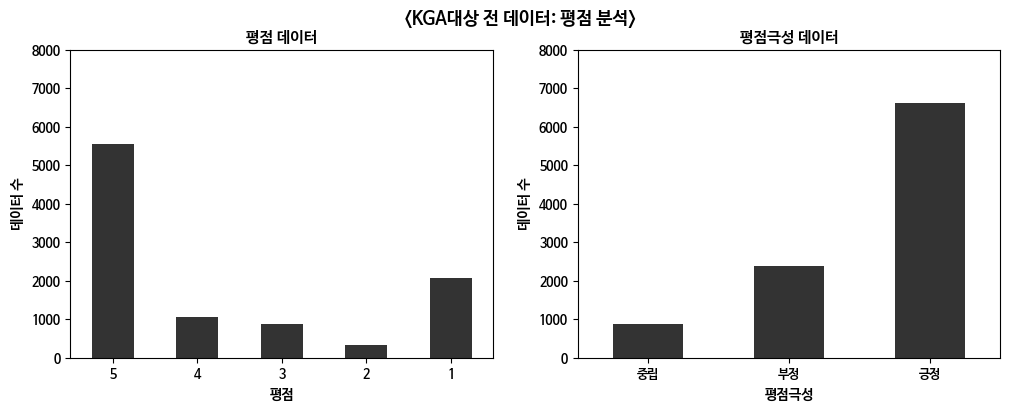

In [ ]:
# 시각화(KGA대상 전 데이터 + 평점/평점극성 데이터)

plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('<KGA대상 전 데이터: 평점 분석>', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
make_plot01("평점", "데이터 수", "평점 데이터", Before_MDunpa_df06["평점"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 8000])

plt.subplot(1, 2, 2)
make_plot01("평점극성", "데이터 수", "평점극성 데이터", Before_MDunpa_df06["평점극성"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 8000])
plt.show()

#### **②시각화: 감성점수 및 감성극성**

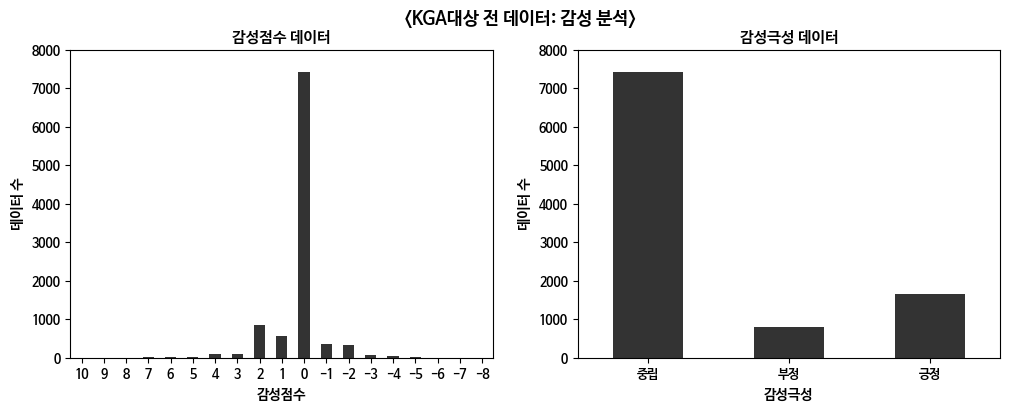

In [ ]:
# 시각화(KGA대상 전 데이터 + 감성점수/감성극성 데이터)

plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('<KGA대상 전 데이터: 감성 분석>', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
make_plot01("감성점수", "데이터 수", "감성점수 데이터", Before_MDunpa_df06["감성점수"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 8000])

plt.subplot(1, 2, 2)
make_plot01("감성극성", "데이터 수", "감성극성 데이터", Before_MDunpa_df06["감성극성"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 8000])
plt.show()

#### **③시각화: 유용성**

유용성
0    8891
1     639
2     131
3      40
4      31
Name: count, dtype: int64


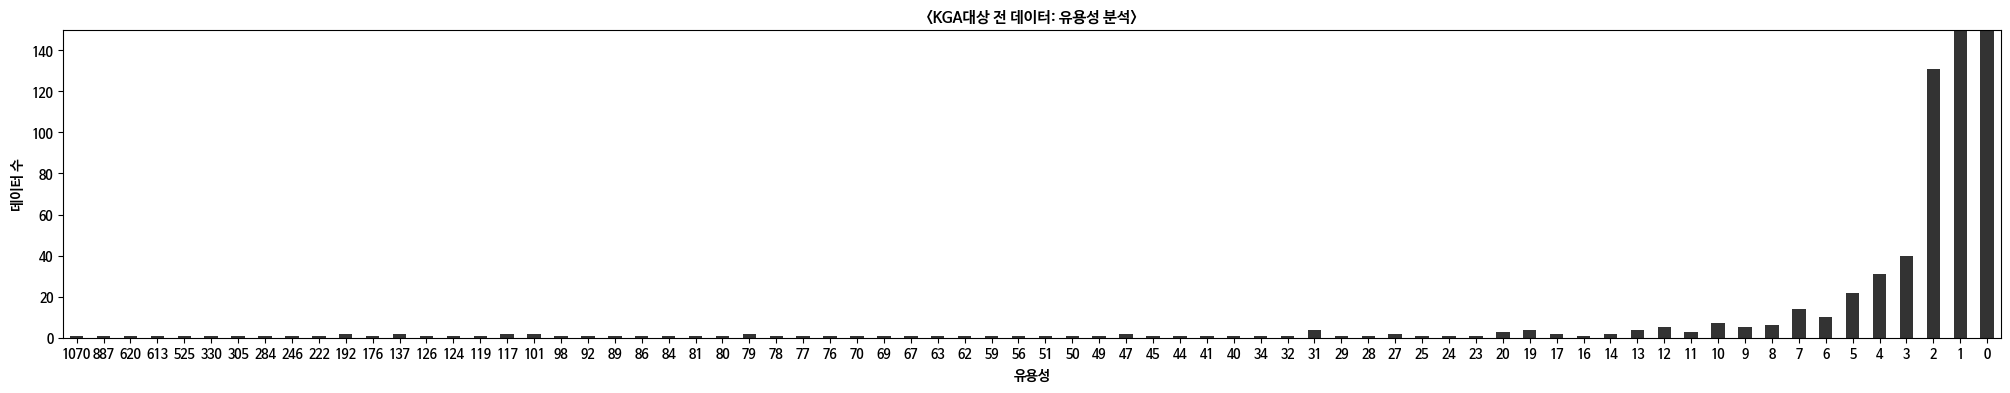

In [ ]:
# 시각화(KGA대상 전 데이터 + 유용성 데이터)

print(Before_MDunpa_df06["유용성"].value_counts().sort_index(ascending=True).head())

make_plot01("유용성", '데이터 수', "<KGA대상 전 데이터: 유용성 분석>", Before_MDunpa_df06["유용성"])
plt.rcParams["figure.figsize"] = (25, 4); plt.ylim([0, 150])
plt.show()

#### **④시각화: 작성일자**

작성일자
2022-03-22      49
2022-03-23     513
2022-03-24    3251
2022-03-25    1583
2022-03-26     622
Name: count, dtype: int64


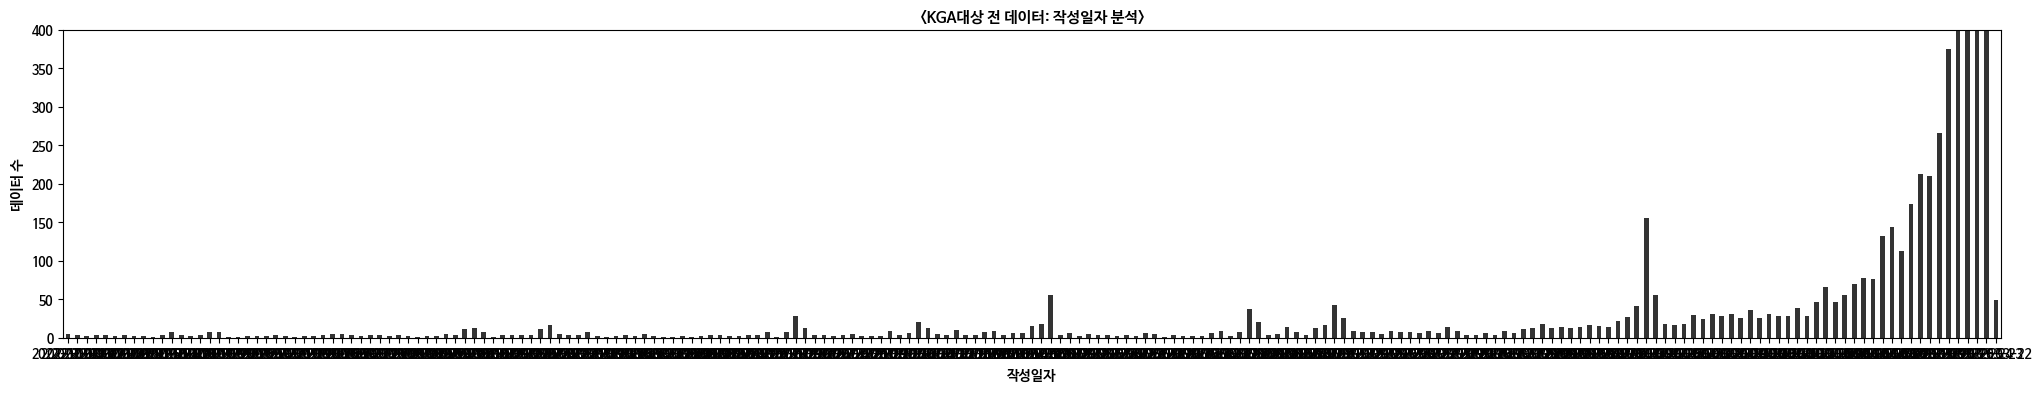

In [ ]:
# 시각화(KGA대상 전 데이터 + 작성일자 데이터)

print(Before_MDunpa_df06["작성일자"].value_counts().sort_index(ascending=True).head())

Before_MDunpa_df06["작성일자"] = Before_MDunpa_df06["작성일자"].astype("str")
make_plot01("작성일자", "데이터 수", "<KGA대상 전 데이터: 작성일자 분석>", Before_MDunpa_df06["작성일자"])
plt.rcParams["figure.figsize"] = (25, 4); plt.ylim([0, 400])
plt.show()

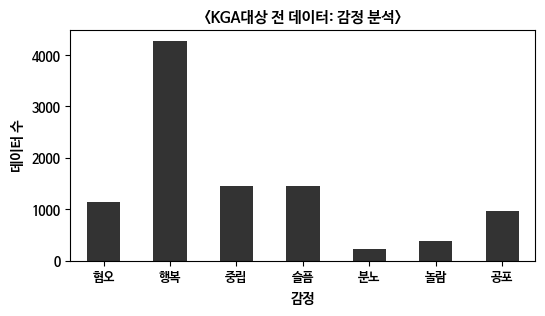

In [ ]:
# 시각화(KGA대상 전 데이터 + 감정 데이터)

make_plot01("감정", "데이터 수", "<KGA대상 전 데이터: 감정 분석>", Before_MDunpa_df06["감정"])
plt.rcParams["figure.figsize"] = (6, 3)
plt.show()

___

### **2. 워드클라우드(빈도분석)**

In [ ]:
## 워드클라우드(빈도분석)(1)
# 품사(명사)를 추출하여, 글자 수가 2개 이상 텍스트만을 선별한 리스트 생성

sample_data03_list01 = []
sample_data03_list02 = []

for i in tqdm(range(0, len(Before_MDunpa_df06))):
  sample_data01 = str(str(str(Before_MDunpa_df06["품사(빈도)"][i]).split("[")[1]).split("]")[0])
  sample_data02 = re.sub(r'[\'\"]', '',sample_data01)
  sample_data03 = re.sub(r'\s+', '', sample_data02).split(",")

  for j in range(0, len(sample_data03)):
    text = sample_data03[j]
    if len(text) < 2:
      pass
    else:
      sample_data03_list01.append(text)
  sample_data03_list02.append(sample_data03_list01)
  sample_data03_list01 = []

100%|██████████| 9883/9883 [00:00<00:00, 56445.85it/s]


In [ ]:
## 워드클라우드(빈도분석)(2)
# 품사(명사)로 구성된 리스트를 다른 리스트에 삽입하여 새로운 리스트 생성

MDunpa_reviews_list = []
for i in tqdm(range(0, len(sample_data03_list02))):
  sample_Data01 = sample_data03_list02[i]
  for j in sample_Data01:
    MDunpa_reviews_list.append(j)

100%|██████████| 9883/9883 [00:00<00:00, 1002280.25it/s]


In [ ]:
## 워드클라우드(빈도분석)(3)
# 분석을 위해 1개 글자 수나 불용어사전의 단어를 필터링

# 불용어사전 구축(분석 결과를 확인하여, 불필요한 단어를 추가 제거)
Stop_Word_dic = ["생각", "사전", "계속", "진짜", "다시", "그냥", "하라",  "다른", "정말", "정도", "시작", "하나", "만큼", "역시", "처음", "지금", "건가", "해도", "확인", "때문", "자꾸", "조금", "아주", "해당", "일단", "무슨",
                 "하니", "부분", "이상", "이후", "오늘", "수가", "추가", "바로", "보고", "이건", "이번", "요즘", "이제", "수라", "가지", "뭔가", "발아", "거의", "중이", "가요", "경우", "그때", "차이", '없나요', '없음', '했다고',
                 '있네요', '하네요', '여러', '나오면', '들어', '하며', '모르고', '없이', '있어요', '뜨는데', '나네요', '만하', '하는',  '했는데', '하려고', '해주세요', '되어', '갑자기', '있어', '나오고', '나게', '주는', '합니다',
                 '하겠습니다', '심합니다', '오면', '해서', '거임', '아니고', '없고', '아닌', '아무리', '싶은데', '해보고', '되게', '되요','하기', '있어서', '했으면', '해야', '주세요', '쓰는데', '되고', '있는데', '않네요', '잇는',
                 '되네요', '떠서', '이나', '누르면', '입니다', '쉽고', '있습니다', '되다가', '하고', '너무', '했습니다', '재밌음', '메카', '필요', '했었는데', '받은', '뜨고', '같은', '하고', '싶다', '건지', '즐길', '있고', '나와서',
                 '하던', '파는', '있는', '하면', '너무', '그렇게', '이긴', '돋네요', '크리', '같아', '됩니다', '하면', '집니다', '해보세요', '아직', '너무', '하나요', '받고', '그대로', '다르게', '해봤는데', '세라', '된다', '그렇고',
                 '모든', '거기', '해보는데', '하세요', '않습니다', '하세요', '하고', '나왔다고', '하면', '하냐', '되었습니다', '입니다', '되는', '않음', '하는데', '않고', '되면', '한다', '않는', '너무', '있었는데', '봐야', '같은', '처럼',
                 '하지', '나와', '한번', '바랍니다', '하니까', '없으면', '있나요', '입니다', '만들었네요', '뜨는', '했던', '로서', '있는', '없어요', '아예', '하면', '','없네요', '관련', '될까', '있지', '하다가', '할려고', '하러', '있네',
                 '됩니다', '같습니다', '하면', '되는', '건지', '같아요', '나고', '나왔다',  '걸까', '없다고', '되는데', '보이네요', '지워', '정이', '하게', '없는', '인지', '나오는데', '없는', '들이', '갑니다', '되니', '데던', '아니라',
                 '없는', '잇어요', '토리', '지네', '만해', '이렇게', '했다가', '기존', '했지만', '있게', '아닌가', '하려', '있음', '받아', '같은데', '없어', '사는', '되네', '이면', '나옴', '마세요', '비해', '근데', '있다고', '걸리고',
                 '있음', '그나마', '그거', '같은데', '먹고', '가능하게', '하죠', '많이', '해놓고', '치는', '팔이', '보이', '좋고', '받을', '이렇게', '나온', '하기가', '있었으면', '하다', '싶어요', '깔고', '깔았는데', '어쩌', '나올',
                 '됐는데', '있도록', '플립', '심하게', '거나', '했을', '떠오르네요', '없어서', '마라', '그게', '해보니', '싶네요', '떠요', '모르겠다', '나왔으면', '아닌데', '많아서', '받나요', '넘게', '이럴', '해보는', '많은', '뜨면서',
                 '봐요', '되는지', '요하', '되서', '봅니다', '보다', '없습니다', '하자', '나오네', '있던', '만이', '남아', '남은', '나오는', '맞는', '꺼면', '나오니', '이미', '돼요', '않은', '들어가', '이리', '하래', '저리', '줘요',
                 '그러는', '위해', '면서', '대로', '같아서', '했음', '뭐임', '까요', '했네', '슈시', '고요', '한참', '해봐야', '주셔서', '그리', '해줬으면', '오고', '겁나', '안주나요', '하구', '거지', '되나', '한다고', '똑같네요',
                 '가네요', '보이지', '그럴', '점점', '해주시길', '확실히', '했고', '같고', '잇습니다', '똑바로', '없다', '놓고', '있지만', '돈슨', '없네', '했는', '점도', '프리', '시도', '주고', '다가', '아직도', '상당히', '걸리는',
                 '지우고', '아니라고', '파이', '솔직히', '나머지', '만들', '있긴', '보니', '없지만', '누가', '깔아도', '해볼', '성도', '지웠다', '아님', '되는데요', '특히', '자체', '그런', '다운', '하다니', '않아', '가는', '했다',
                 '뜨네요', '있을', '오지', '겁니다', '듭니', '들어가서', '로만', '뜹니다', '일시', '는데', '나서', '되지', '없는데', '했는데도', '먹을', '된다고', '보입니다', '받는', '아닌가요', '했네요', '해주시면', '안됨', '이따',
                 '왔는데', '잘만', '삭제', '요한', '되었네요', '금도', '받아서', '사실', '해야지', '있다는', '아니냐', '가볍게', '따로', '달라', '잡고', '놓은', '되나요', '불가',  '할만', '만든', '도도', '기다린', '하네', '하신', '가능',
                 '시키는', '걸려', '나을', '없나','젖어', '년도', '납니다', '심해서', '였는데', '없다는', '원래', '모르겠지만', '전혀', '들어가면', '대한', '더욱', '완성', '받으면', '월일', '문구', '말들었네', '오나요', '기는', '할게요',
                 '드디어', '꾸준히', '그것', '유지', '런가', '심한', '별로', '나름', '어릴', '믿고', '년전', '굿굿', '제일', '같음', '돼는', '오랜', '돼는', '인생', '기다리고', '감사합니다', '최근', '바뀐', '빠져', '나오네요', '원하는',
                 '걸리네', '클릭', '할게요', '맞게', '해주세', '같네요', '초반', '나오게', '해본', '이러면', '들어서', '끄고', '있으면', '만들어', '먹는', '돋는', '이유', '드립니다',  '없을', '시킨', '데이터', '같네', '괜히', '분명',
                 '하려는', '오래', '개인', '시대', '참고', '별개', '개심', '크게', '보네', '그런지', '초창', '보면', '성은', '뭐라','썼는데', '사용', '자사', '해볼게요', '할려니', '나은', '너무나', '하루', '만들었음', '돋고', '눌러도',
                 '눌렸는데', '도대체', '금방', '있나', '게임', '모바일', '던파', '던전앤파이터', '다른']

def count_frequency(my_list):
    count = {}
    for item in my_list:
      if len(item)<= 1 or item in Stop_Word_dic:
        pass
      else:
        count[item] = count.get(item, 0) + 1
    return count

MDunpa_reviews_words = count_frequency(MDunpa_reviews_list)
MDunpa_reviews_words = dict(sorted(MDunpa_reviews_words.items(), key = lambda item: item[1], reverse = True))

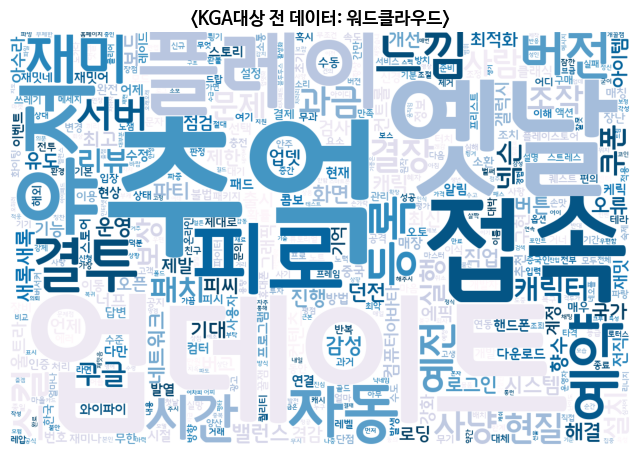

In [ ]:
## 워드클라우드(빈도분석)(4)
# 분석 결과 확인

# 옵션 설정
font_path = "/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/font/GodoM.ttf"
wc = WordCloud(width = 1200, height = 800, background_color = "white", random_state = 0, font_path = font_path, colormap = "PuBu", max_words = 500)

# 시각화
plt.imshow(wc.generate_from_frequencies(MDunpa_reviews_words))
plt.title("<KGA대상 전 데이터: 워드클라우드>", fontsize=13, fontweight ="bold")
plt.rcParams["figure.figsize"] = (8,6)
plt.axis("off")
plt.show()

___

### **3. 네트워크분석**

In [ ]:
## 네트워크분석(1)
# 불용어사전의 단어를 제거한 리스트 재정의

sample_data01_list = []
sample_data02_list = []
semi_Stop_Word_dic = [""]

for one_list in tqdm(sample_data03_list02):
  for word in one_list:
    if len(word)<= 1 or word in semi_Stop_Word_dic:
      pass
    else:
      sample_data01_list.append(word)
  if len(sample_data01_list) == 0:
    pass
  else:
    sample_data02_list.append(sample_data01_list)
  sample_data01_list = []

100%|██████████| 9883/9883 [00:00<00:00, 441842.17it/s]


In [ ]:
## 네트워크분석(2)
# 연관성 분석의 성과를 측정하는 지지도(support) 측정 및 필터링

result = (list(apriori(sample_data02_list, min_support=0.01)))
df = pd.DataFrame(result)
df["length"] = df["items"].apply(lambda x: len(x))
df = df[(df["length"] == 2) & (df["support"]>=0.01)].sort_values(by = "support", ascending = False)

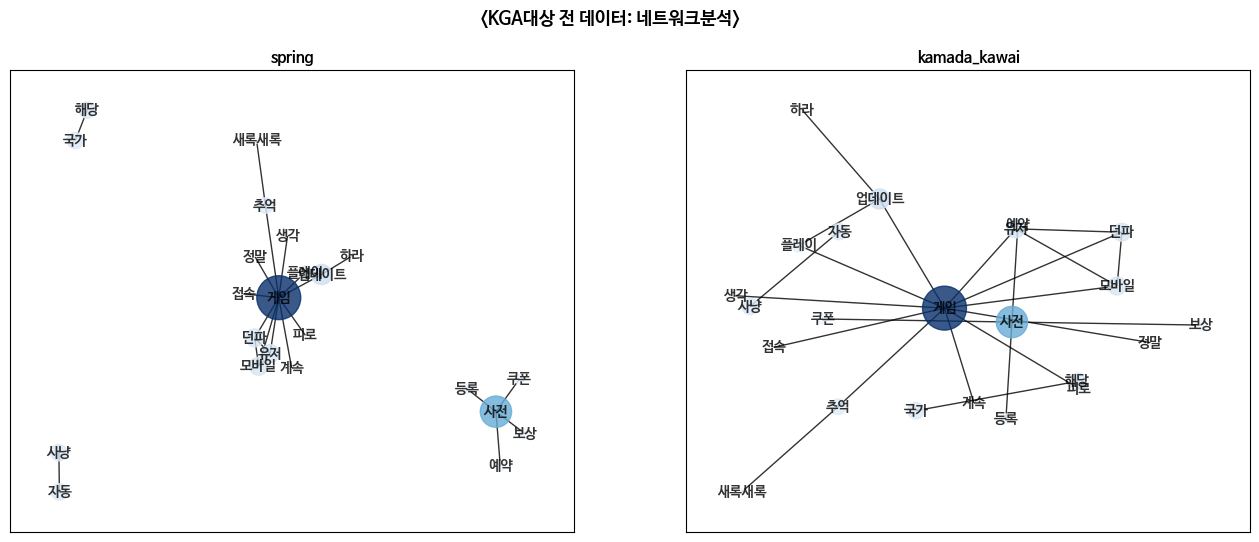

In [ ]:
## 네트워크분석(3)
# 분석 결과를 2개 레이아웃(spring_layout, kamada_kawai_layout)으로 출력

f, axes = plt.subplots(1, 2)
f.set_size_inches((16, 6))

# 입력값 설정
G = nx.Graph()
ar = (df["items"])
G.add_edges_from(ar)
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 1000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

# 레이아웃 타입 설정
layouts = {'spring': nx.spring_layout(G),
           'kamada_kawai':nx.kamada_kawai_layout(G)}    # 중간을 중심으로 구성

# 네트워크 출력
plt.suptitle('<KGA대상 전 데이터: 네트워크분석>', fontsize=13, fontweight ="bold")
for i, kv in enumerate(layouts.items()):
  # 레리아웃 타입, 지지도값, 인덱스 위치
  title, pos, ax = kv[0], kv[1], axes[i]
  nx.draw_networkx(G,
                   font_family = "NanumBarunGothic",    # 노트 폰트 설정
                   pos = kv[1],                         # 레이아웃 타입 설정
                   node_size   = nsize,                 # 노트 크기 설정(2)
                   node_color  = list(pr.values()),     # 노드 크기에 따른 색상 정도 설정
                   cmap        = plt.cm.Blues,          # 노트 색상 설정
                   font_size   = 10,                    # 폰트 크기 설정
                   font_color  = 'k',                   # 폰드 색상 설정
                   font_weight = "bold",                # 폰트 굵기 설정
                   alpha       = 0.8,                   # 폰트 투명도 설정
                   ax=ax)
  ax.set_title("{}".format(title), fontsize=11, fontweight ="bold")
  ax.axis('on')
plt.show()

___

### **4. 군집분석**

#### **군집분석(k=3)을 대상으로 트렌드 분석**

In [ ]:
# 군집분석(k=3) 결과 확인
print(Before_MDunpa_df06["군집_03"].value_counts().sort_index(ascending=True))

군집_03
0    9849
1       5
2      29
Name: count, dtype: int64


##### **①3개 군집: 평점, 평균 및 데이터 수**

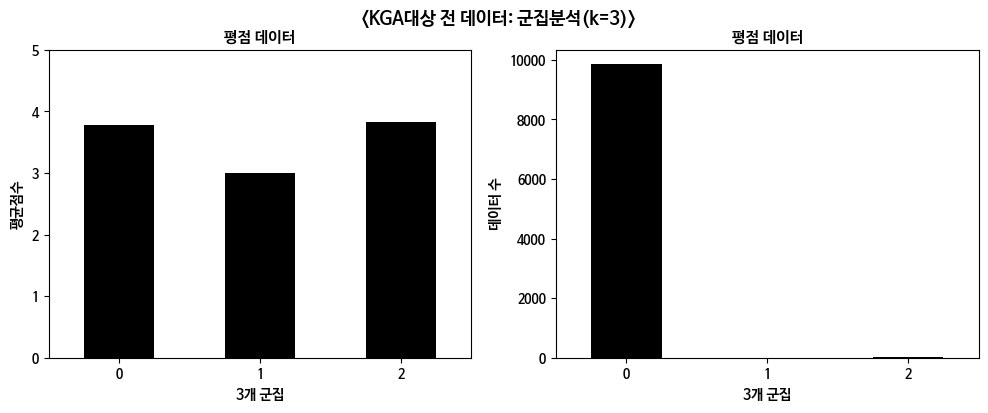

In [ ]:
# 시각화(KGA대상 전 데이터 + 군집분석(k=3) + 평점평균 및 데이터 수)

plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('<KGA대상 전 데이터: 군집분석(k=3)>', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
groupby_make_plot02('3개 군집', '평균점수','평점 데이터', "군집_03", "평점", Before_MDunpa_df06, "mean")
plt.ylim([0, 5])

plt.subplot(1, 2, 2)
groupby_make_plot02('3개 군집', '데이터 수','평점 데이터',"군집_03", "평점", Before_MDunpa_df06, "count")

plt.show()

##### **②3개 군집: 유용성, 평균 및 데이터 수**

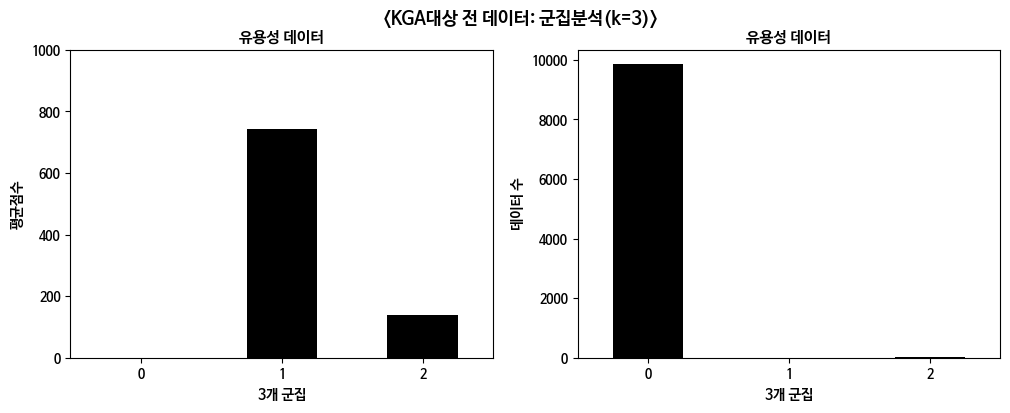

In [ ]:
# 시각화(KGA대상 전 데이터 + 군집분석(k=3) + 유용성평균 및 데이터 수)

plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('<KGA대상 전 데이터: 군집분석(k=3)>', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
groupby_make_plot02('3개 군집', '평균점수', '유용성 데이터', "군집_03", "유용성", Before_MDunpa_df06, "mean")
plt.ylim([0, 1000])

plt.subplot(1, 2, 2)
groupby_make_plot02('3개 군집', '데이터 수', '유용성 데이터', "군집_03", "유용성",Before_MDunpa_df06, "count")

plt.show()

##### **③3개 군집: 감성점수, 평균 및 데이터 수**

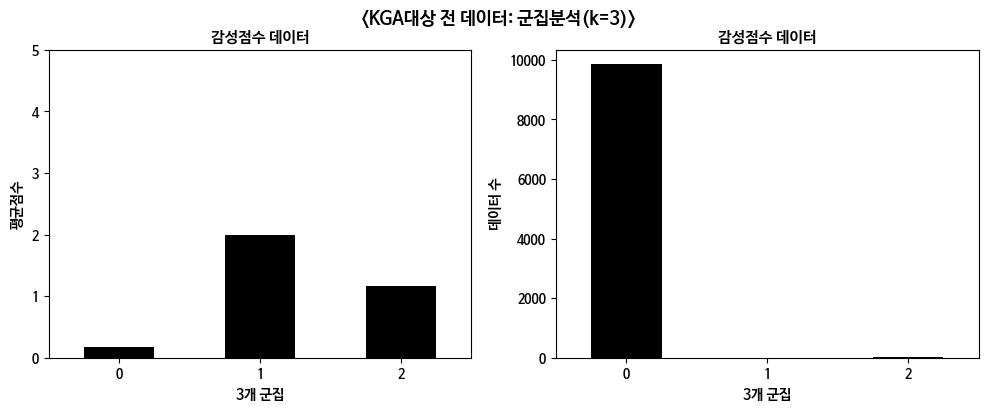

In [ ]:
# 시각화(KGA대상 전 데이터 + 군집분석(k=4) + 감성점수평균 및 데이터 수)

plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('<KGA대상 전 데이터: 군집분석(k=3)>', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
groupby_make_plot02('3개 군집', '평균점수','감성점수 데이터', "군집_03", "감성점수",Before_MDunpa_df06, "mean")
plt.ylim([0, 5])

plt.subplot(1, 2, 2)
groupby_make_plot02('3개 군집', '데이터 수', '감성점수 데이터',"군집_03", "감성점수",Before_MDunpa_df06, "count")

plt.show()

##### **④3개 군집: 평점 및 세부평점, 평균**

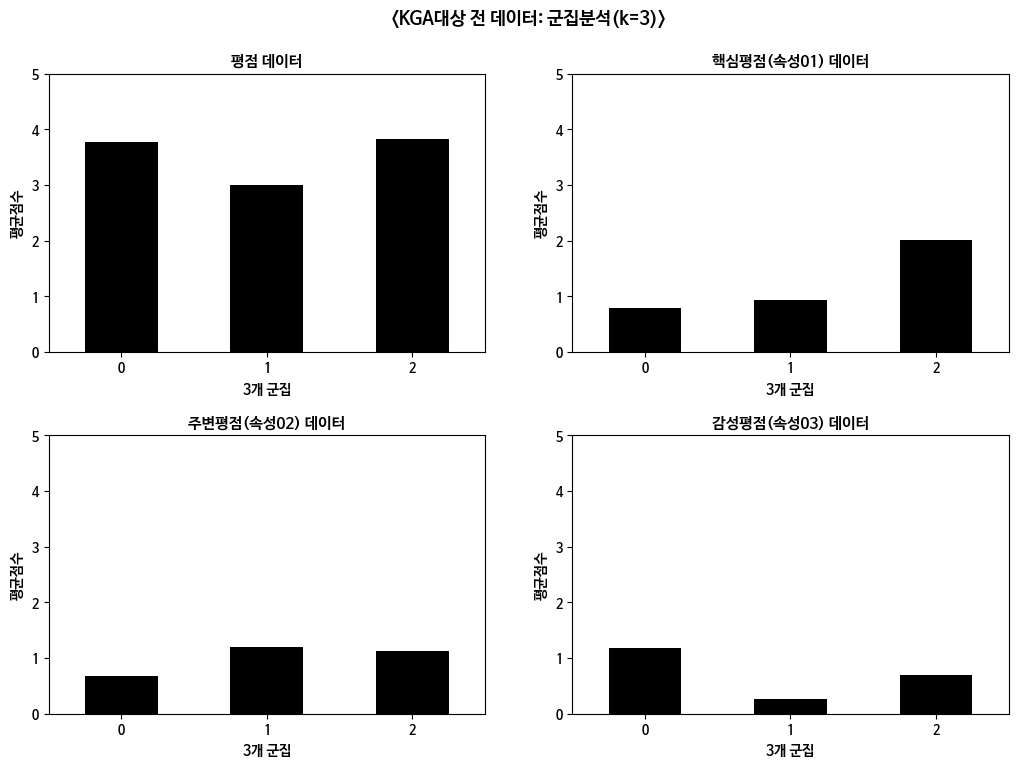

In [ ]:
# 시각화(KGA대상 전 데이터 + 군집분석(k=3) + 평점 및 세부평점의 평균)

plt.rcParams["figure.figsize"] = (12,8)
plt.suptitle('<KGA대상 전 데이터: 군집분석(k=3)>', fontsize=13, fontweight ="bold")

plt.subplot(2, 2, 1)
groupby_make_plot02('3개 군집', '평균점수',
                    '평점 데이터',
                    "군집_03", "평점",
                    Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.subplot(2, 2, 2)
groupby_make_plot02('3개 군집', '평균점수',
                    '핵심평점(속성01) 데이터',
                    "군집_03", "핵심평점(속성01)",
                    Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

plt.subplot(2, 2, 3)
groupby_make_plot02('3개 군집', '평균점수',
                    '주변평점(속성02) 데이터',
                    "군집_03", "주변평점(속성02)",
                    Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.subplot(2, 2, 4)
groupby_make_plot02('3개 군집', '평균점수',
                    '감성평점(속성03) 데이터',
                    "군집_03", "감성평점(속성03)",
                    Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.show()

##### **⑤3개 군집: 0집단 워드클라우드**

In [ ]:
# 군집분석(k=3) 결과에 대한 데이터 정의
zero  = Before_MDunpa_df06[Before_MDunpa_df06["군집_03"]=="0"]; zero = zero.reset_index();  del zero["index"]
one   = Before_MDunpa_df06[Before_MDunpa_df06["군집_03"]=="1"]; one  = one.reset_index();   del one["index"]
two   = Before_MDunpa_df06[Before_MDunpa_df06["군집_03"]=="2"]; two  = two.reset_index();   del two["index"]

100%|██████████| 9849/9849 [00:00<00:00, 974331.34it/s]


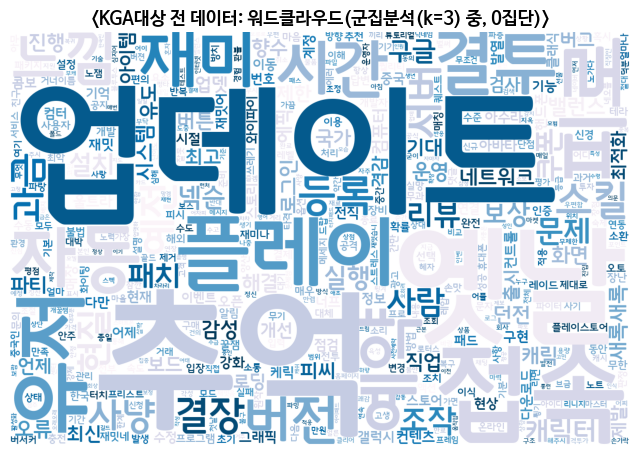

In [ ]:
## 워드클라우드
# 군집분석(k=3) 중, 0집단 결과

# 1. 명사 품사를 백업해둔 리스트를 불러와 전처리하여 리스트 형태로 변환
sample_data03_list01 = []
sample_data03_list02 = []

for i in tqdm(range(0, len(zero))):
  sample_data01 = str(str(str(zero["품사(빈도)"][i]).split("[")[1]).split("]")[0])
  sample_data02 = re.sub(r'[\'\"]', '',sample_data01)
  sample_data03 = re.sub(r'\s+', '', sample_data02).split(",")

  for j in range(0, len(sample_data03)):
    text = sample_data03[j]
    if len(text) < 2:
      pass
    else:
      sample_data03_list01.append(text)
  sample_data03_list02.append(sample_data03_list01)
  sample_data03_list01 = []


# 2. 명사 품사를 담은 리스트를 새로운 리스트에 삽입
MDunpa_reviews_list = []
for i in tqdm(range(0, len(sample_data03_list02))):
  sample_Data01 = sample_data03_list02[i]
  for j in sample_Data01:
    MDunpa_reviews_list.append(j)


# 3. LDA모델을 통해 추출한 결과 중에서 불필요한 단어를 전처리(불용어사전의 경우, 상기 과정에서 이미 구축 完)
def count_frequency(my_list):
    count = {}
    for item in my_list:
      if len(item)<= 1 or item in Stop_Word_dic:
        pass
      else:
        count[item] = count.get(item, 0) + 1
    return count
MDunpa_reviews_words = count_frequency(MDunpa_reviews_list)                                                            # 토큰 전처리 함수를 통한 Dict형태로 빈도 측정
MDunpa_reviews_words = dict(sorted(MDunpa_reviews_words.items(), key = lambda item: item[1], reverse = True))          # Dict형태로 측정된 결과 정렬


# 4. 분석 결과 확인
plt.imshow(wc.generate_from_frequencies(MDunpa_reviews_words))
plt.title('<KGA대상 전 데이터: 워드클라우드(군집분석(k=3) 중, 0집단)>', fontsize=13, fontweight ="bold")
plt.rcParams["figure.figsize"] = (8,6)
plt.axis("off")
plt.show()

##### **⑥3개 군집: 1집단 워드클라우드**

100%|██████████| 5/5 [00:00<00:00, 40407.55it/s]


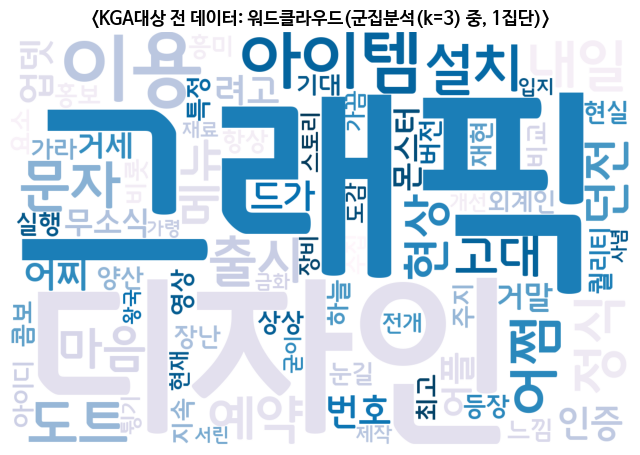

In [ ]:
## 워드클라우드
# 군집분석(k=3) 중, 1집단 결과

# 1. 명사 품사를 백업해둔 리스트를 불러와 전처리하여 리스트 형태로 변환
sample_data03_list01 = []
sample_data03_list02 = []

for i in tqdm(range(0, len(one))):
  sample_data01 = str(str(str(one["품사(빈도)"][i]).split("[")[1]).split("]")[0])
  sample_data02 = re.sub(r'[\'\"]', '',sample_data01)
  sample_data03 = re.sub(r'\s+', '', sample_data02).split(",")

  for j in range(0, len(sample_data03)):
    text = sample_data03[j]
    if len(text) < 2:
      pass
    else:
      sample_data03_list01.append(text)
  sample_data03_list02.append(sample_data03_list01)
  sample_data03_list01 = []


# 2. 명사 품사를 담은 리스트를 새로운 리스트에 삽입
MDunpa_reviews_list = []
for i in tqdm(range(0, len(sample_data03_list02))):
  sample_Data01 = sample_data03_list02[i]
  for j in sample_Data01:
    MDunpa_reviews_list.append(j)


# 3. LDA모델을 통해 추출한 결과 중에서 불필요한 단어를 전처리(불용어사전의 경우, 상기 과정에서 이미 구축 完)
def count_frequency(my_list):
    count = {}
    for item in my_list:
      if len(item)<= 1 or item in Stop_Word_dic:
        pass
      else:
        count[item] = count.get(item, 0) + 1
    return count
MDunpa_reviews_words = count_frequency(MDunpa_reviews_list)                                                           # 함수를 통해 dict 형태로 빈도 측정
MDunpa_reviews_words = dict(sorted(MDunpa_reviews_words.items(), key = lambda item: item[1], reverse = True))         # dict 형태 측정 결과를 정렬


# 4. 분석 결과 확인
plt.imshow(wc.generate_from_frequencies(MDunpa_reviews_words))
plt.title('<KGA대상 전 데이터: 워드클라우드(군집분석(k=3) 중, 1집단)>', fontsize=13, fontweight ="bold")
plt.rcParams["figure.figsize"] = (8,6)
plt.axis("off")
plt.show()

##### **⑦3개 군집: 2집단 워드클라우드**

100%|██████████| 29/29 [00:00<00:00, 135601.80it/s]


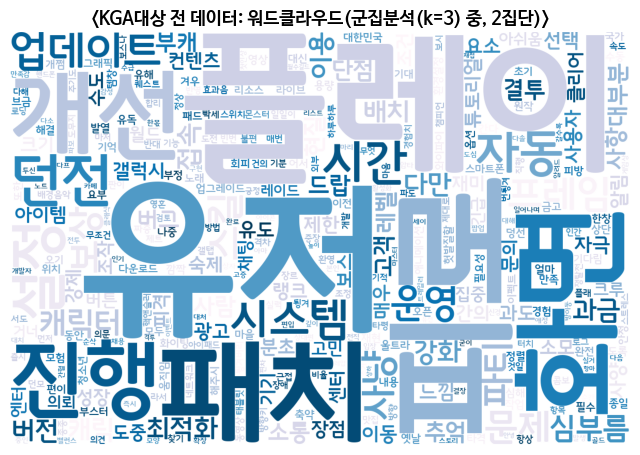

In [ ]:
## 워드클라우드
# 군집분석(k=3) 중, 2집단 결과

# 1. 명사 품사를 백업해둔 리스트를 불러와 전처리하여 리스트 형태로 변환
sample_data03_list01 = []
sample_data03_list02 = []

for i in tqdm(range(0, len(two))):
  sample_data01 = str(str(str(two["품사(빈도)"][i]).split("[")[1]).split("]")[0])
  sample_data02 = re.sub(r'[\'\"]', '',sample_data01)
  sample_data03 = re.sub(r'\s+', '', sample_data02).split(",")

  for j in range(0, len(sample_data03)):
    text = sample_data03[j]
    if len(text) < 2:
      pass
    else:
      sample_data03_list01.append(text)
  sample_data03_list02.append(sample_data03_list01)
  sample_data03_list01 = []


# 2. 명사 품사를 담은 리스트를 새로운 리스트에 삽입
MDunpa_reviews_list = []
for i in tqdm(range(0, len(sample_data03_list02))):
  sample_Data01 = sample_data03_list02[i]
  for j in sample_Data01:
    MDunpa_reviews_list.append(j)


# 3. LDA모델을 통해 추출한 결과 중에서 불필요한 단어를 전처리(불용어사전의 경우, 상기 과정에서 이미 구축 完)
def count_frequency(my_list):
    count = {}
    for item in my_list:
      if len(item)<= 1 or item in Stop_Word_dic:
        pass
      else:
        count[item] = count.get(item, 0) + 1
    return count
MDunpa_reviews_words = count_frequency(MDunpa_reviews_list)                                                           # 함수를 통해 dict 형태로 빈도 측정
MDunpa_reviews_words = dict(sorted(MDunpa_reviews_words.items(), key = lambda item: item[1], reverse = True))         # dict 형태 측정 결과를 정렬


# 4. 분석 결과 확인
plt.imshow(wc.generate_from_frequencies(MDunpa_reviews_words))
plt.title('<KGA대상 전 데이터: 워드클라우드(군집분석(k=3) 중, 2집단)>', fontsize=13, fontweight ="bold")
plt.rcParams["figure.figsize"] = (8,6)
plt.axis("off")
plt.show()

___

### **5. 속성분석**

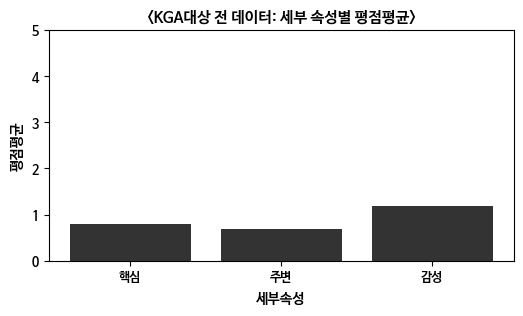

In [ ]:
# 시각화(KGW대상 전 데이터 + 세부평점 평균)

# 속성평점의 평균 측정
Before_Key_number    = Before_MDunpa_df06['핵심평점(속성01)'].mean()
Before_Around_number = Before_MDunpa_df06['주변평점(속성02)'].mean()
Before_senti_number  = Before_MDunpa_df06['감성평점(속성03)'].mean()
score_aspect_03 = [Before_Key_number, Before_Around_number, Before_senti_number]

# 시각화 옵션 설정
plt.rcParams["figure.figsize"] = (6, 3)
label = ["핵심", "주변", "감성"]; x = np.arange(len(label))
plt.xticks(x, label); plt.ylim([0, 5])
plot_option02("세부속성", "평점평균", "<KGA대상 전 데이터: 세부 속성별 평점평균>")
plt.bar(x-0.0, score_aspect_03, color='k', alpha = 0.8)
plt.show()

___

### **6. 기타분석**

#### **유용성이 100개 이상인 유저의 데이터 분석**

In [ ]:
# 100개 이상 유용성 데이터 구축

hundred_Before_MDunpa_df06 = Before_MDunpa_df06[Before_MDunpa_df06["유용성"]>=100]
hundred_Before_MDunpa_df06 = hundred_Before_MDunpa_df06.reset_index()
del hundred_Before_MDunpa_df06["index"]
print(hundred_Before_MDunpa_df06.shape)

(22, 24)


##### **①시각화: 평점 및 세부평점, 평균**

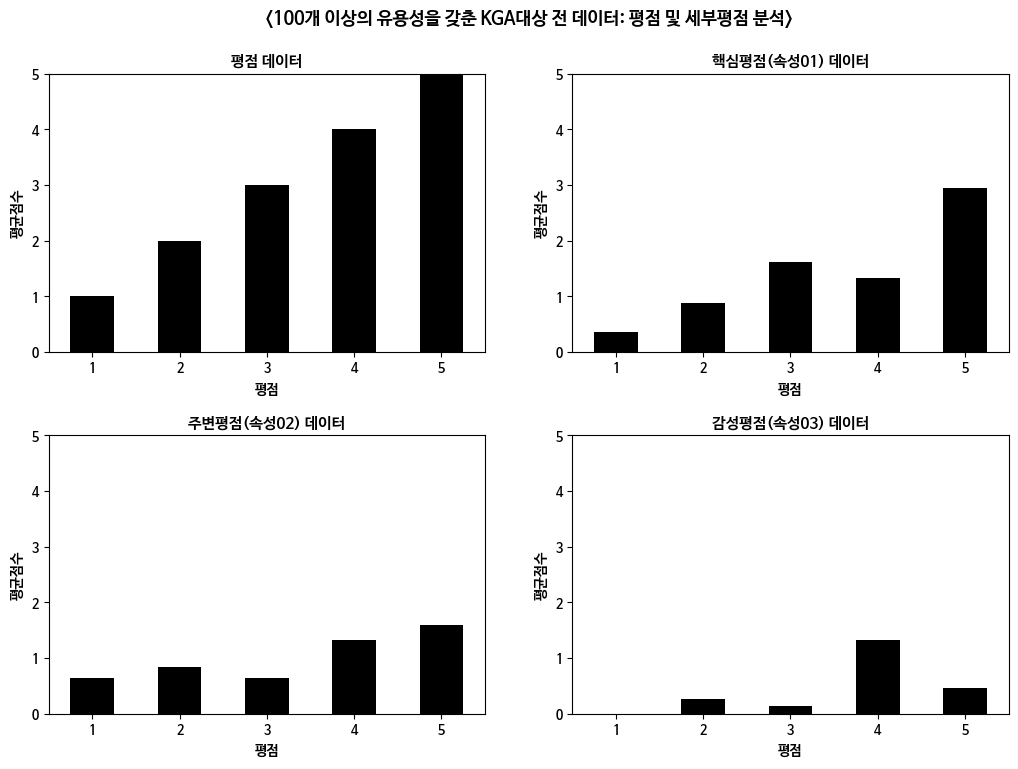

In [ ]:
# 시각화(100개 이상의 유용성을 갖춘 KGA대상 전 데이터 + 평점 및 세부평점 평균)


plt.rcParams["figure.figsize"] = (12,8)
plt.suptitle('<100개 이상의 유용성을 갖춘 KGA대상 전 데이터: 평점 및 세부평점 분석>', fontsize=13, fontweight ="bold")

plt.subplot(2, 2, 1)
groupby_make_plot02('평점', '평균점수','평점 데이터',"평점", "평점",hundred_Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.subplot(2, 2, 2)
groupby_make_plot02('평점', '평균점수','핵심평점(속성01) 데이터',"평점", "핵심평점(속성01)",hundred_Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

plt.subplot(2, 2, 3)
groupby_make_plot02('평점', '평균점수','주변평점(속성02) 데이터',"평점", "주변평점(속성02)",hundred_Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.subplot(2, 2, 4)
groupby_make_plot02('평점', '평균점수','감성평점(속성03) 데이터',"평점", "감성평점(속성03)",hundred_Before_MDunpa_df06, "mean"); plt.ylim([0, 5])

plt.show()

##### **②시각화: 감성점수 데이터 수**

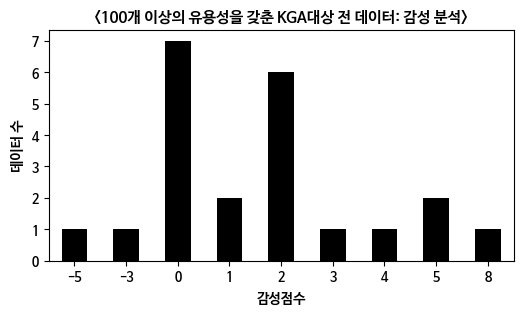

In [ ]:
# 시각화(100개 이상의 유용성을 갖춘 KGKGA대상 전 데이터 + 평점 및 세부평점 평균)

plt.rcParams["figure.figsize"] = (6, 3)
groupby_make_plot02('감성점수', '데이터 수','<100개 이상의 유용성을 갖춘 KGA대상 전 데이터: 감성 분석>',"감성점수", "감성점수",hundred_Before_MDunpa_df06, "count")
plt.show()

##### **③시각화: 감정 데이터 수**

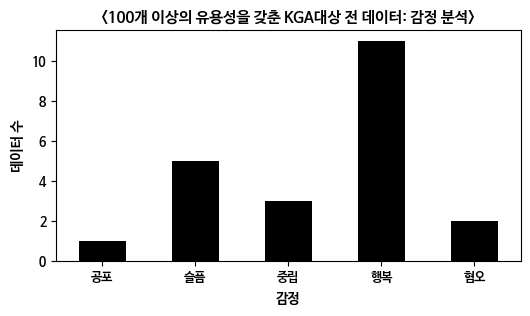

In [ ]:
# 시각화(100개 이상의 유용성을 갖춘 KGA대상 전 데이터 + 감성점수 데이터 수)

plt.rcParams["figure.figsize"] = (6, 3)
groupby_make_plot02('감정', '데이터 수','<100개 이상의 유용성을 갖춘 KGA대상 전 데이터: 감정 분석>',"감정", "감정",hundred_Before_MDunpa_df06, "count")
plt.show()

##### **④시각화: 워드클라우드(빈도분석)**

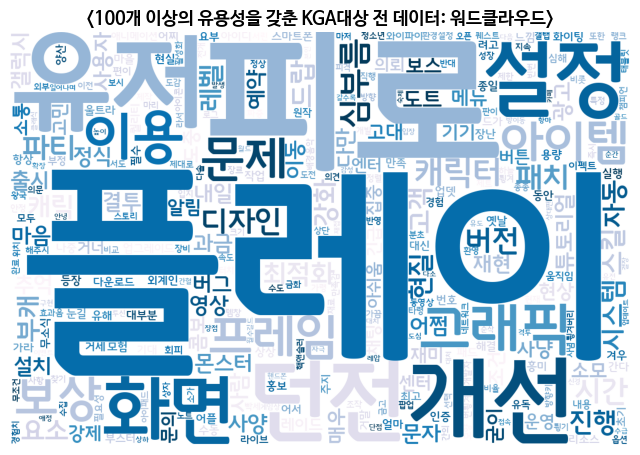

In [ ]:
## 워드클라우드
# 100개 이상의 유용성을 갖는 KGA대상 전 데이터 결과 확인

# 1. 명사 품사를 백업해둔 리스트를 불러와 전처리하여 리스트 형태로 변환
sample_data03_list01 = []
sample_data03_list02 = []

for i in tqdm(range(0, len(hundred_Before_MDunpa_df06))):
  sample_data01 = str(str(str(hundred_Before_MDunpa_df06["품사(빈도)"][i]).split("[")[1]).split("]")[0])
  sample_data02 = re.sub(r'[\'\"]', '',sample_data01)
  sample_data03 = re.sub(r'\s+', '', sample_data02).split(",")

  for j in range(0, len(sample_data03)):
    text = sample_data03[j]
    if len(text) < 2:
      pass
    else:
      sample_data03_list01.append(text)
  sample_data03_list02.append(sample_data03_list01)
  sample_data03_list01 = []


# 2. 명사 품사를 담은 리스트를 새로운 리스트에 삽입
MDunpa_reviews_list = []
for i in tqdm(range(0, len(sample_data03_list02))):
  sample_Data01 = sample_data03_list02[i]
  for j in sample_Data01:
    MDunpa_reviews_list.append(j)


# 3. LDA모델을 통해 추출한 결과 중에서 불필요한 단어를 전처리(불용어사전의 경우, 상기 과정에서 이미 구축 完)
def count_frequency(my_list):
    count = {}
    for item in my_list:
      if len(item)<= 1 or item in Stop_Word_dic:
        pass
      else:
        count[item] = count.get(item, 0) + 1
    return count
MDunpa_reviews_words = count_frequency(MDunpa_reviews_list)                                                           # 함수를 통해 dict 형태로 빈도 측정
MDunpa_reviews_words = dict(sorted(MDunpa_reviews_words.items(), key = lambda item: item[1], reverse = True))         # dict 형태 측정 결과를 정렬


# 4. 분석 결과 확인
plt.imshow(wc.generate_from_frequencies(MDunpa_reviews_words))
plt.title("<100개 이상의 유용성을 갖춘 KGA대상 전 데이터: 워드클라우드>", fontsize=13, fontweight ="bold")
plt.rcParams["figure.figsize"] = (8,6)
plt.axis("off")
plt.show()

___